ici on fait un bilan des flux turbulents et de rayonnement sur T2R

In [1]:
import os
import xarray as xr
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

repertoire_courant=os.getcwd()
repertoire_figures=repertoire_courant+r"\\"+r"figures"+r"\\"
print(repertoire_courant)
repertoire_fichiers=repertoire_courant+r"\Outputs_EddyPro"+r"\\"
print("chargement des données")
T2_1_30min=xr.open_dataset(repertoire_fichiers+r"T2_RE_bas_2min_full_output.nc").coarsen(temps=15,side='left').mean()
T2_2_30min=xr.open_dataset(repertoire_fichiers+r"T2_RE_haut_2min_full_output.nc").coarsen(temps=15,side='left').mean()

T2_1_30min=T2_1_30min.assign(wind_dir=(T2_1_30min['wind_dir']+180)%360)
T2_2_30min=T2_2_30min.assign(wind_dir=(T2_2_30min['wind_dir']+180)%360)

z_T2_1_30min = np.array([1.2 if date < np.datetime64("2023-09-06 09:00:00") else 1.05
                        for date in T2_1_30min.coords['temps'].values])
z_T2_2_30min = np.ones(T2_2_30min.coords['temps'].values.size)*2.0
z_T2_1_30min=xr.DataArray(data=z_T2_1_30min,
                         dims=['temps'],
                         coords={'temps':('temps',T2_1_30min.coords['temps'].values)})
T2_1_30min=T2_1_30min.assign({'instrument_height':z_T2_1_30min})

z_T2_2_30min=xr.DataArray(data=z_T2_2_30min,
                         dims=['temps'],
                         coords={'temps':('temps',T2_2_30min.coords['temps'].values)})
T2_2_30min=T2_2_30min.assign({'instrument_height':z_T2_2_30min})


""""
T2_1_2min=T2_1_2min.assign({'instrument_height':('temps',z_T2_1_2min)},
                           coords={'temps':T2_1_2min.coords['temps'].values})
T2_2_2min=T2_2_2min.assign({'instrument_height':('temps',z_T2_2_2min)},
                           coords={'temps':z_T2_2_2min.coords['temps'].values})
T2_1_30min=T2_1_30min.assign({'instrument_height':('temps',z_T2_1_30min)},
                           coords={'temps':T2_1_30min.coords['temps'].values})
T2_2_30min=T2_2_30min.assign({'instrument_height':('temps',z_T2_2_30min)},
                           coords={'temps':z_T2_2_30min.coords['temps'].values})
"""

print(T2_1_30min.data_vars)

Df=pd.read_csv(repertoire_courant+r'\T2_snowfox_lf.dat',header=1,skiprows=lambda x: x in [2, 3])
series={}
tmin_serie=np.datetime64('2023-09-01 00:30:00')
tmax_serie=np.datetime64('2023-09-08 09:00:00')
date = pd.to_datetime(Df['TIMESTAMP'],format='mixed')

for variables in Df.columns:
    if variables in ['TIMESTAMP','RECORD','Batt_Min'] : pass
    else : 
        series[variables]=pd.Series(Df[variables].astype('float64').values,
                                    index=date,
                                    name=variables).truncate(before=tmin_serie,
                                                             after=tmax_serie).resample('30min').mean()
        #series[variables]=pd.Series(Df[variables].astype('float64').values,index=date,name=variables)
Ds_meteo=Df.to_xarray().assign_coords({'index':date}).drop_vars('TIMESTAMP').rename({'index':'temps'})
print(Ds_meteo)
print("fait")



C:\Users\evanl\Documents\Stage IGE
chargement des données
Data variables:
    daytime                  (temps) float64 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    Tau                      (temps) float64 -0.02501 -0.01129 ... -0.01453
    qc_Tau                   (temps) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    H                        (temps) float64 -34.51 -41.35 ... -51.8 -61.79
    qc_H                     (temps) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    LE                       (temps) float64 12.43 11.76 9.874 ... 15.41 43.07
    qc_LE                    (temps) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    h2o_flux                 (temps) float64 0.2766 0.2617 ... 0.3434 0.9608
    qc_h2o_flux              (temps) float64 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0
    H_strg                   (temps) float64 0.4668 0.526 ... 0.8919 -0.5324
    LE_strg                  (temps) float64 -3.604 -3.787 ... -0.6336 0.3804
    h2o_strg                 (temps) float64 -0.08017 -0.0

In [2]:
import Bulk

z_0=0.001#m
z_t=z_q=1.0e-2*z_0

H_bulk_1=Bulk.H_bulk(T2_1_30min,z0=z_0,zt=z_t)
LE_bulk_1=Bulk.LE_bulk(T2_1_30min,z0=z_0,zq=z_q)

appel wT
zt 1e-05
appel u_s()
z0 0.001
appel wq
zq 1e-05
appel u_s()
z0 0.001


T_surface = 273.15
LW_out = 315.6578223008046 W/m^2


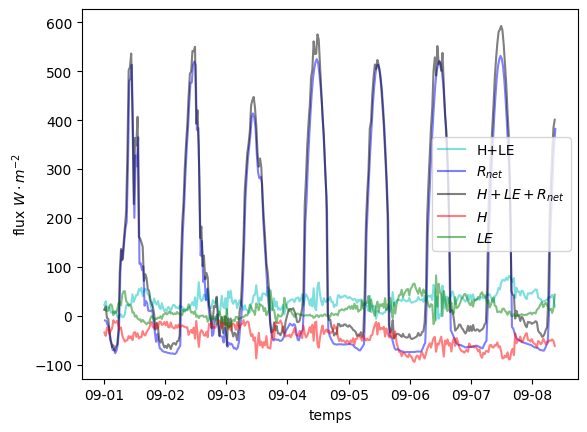

In [3]:
sigma=5.670374419e-8
T_surface = 273.15#K
LW_out=sigma*(T_surface**4)
print(f"T_surface = {T_surface}")
print(f"LW_out = {LW_out} W/m^2")
tps_T2R=T2_1_30min.coords['temps'].values
tps_T2_lf=series['SWin_Avg'].index.values

R_net=series['LWinCor_Avg'].values+series['SWin_Avg'].values-series['SWout_Avg'].values-LW_out
Turb_net=-(T2_1_30min['H']+T2_1_30min['LE'])
Turb_net_Bulk=-(H_bulk_1+LE_bulk_1)
SEB_net=R_net+Turb_net
SEB_net_Bulk=R_net+Turb_net_Bulk


SEB_jour=pd.Series(SEB_net, index=tps_T2R).resample('24H').mean()

LWin_jour=series['LWinCor_Avg'].resample('24H').mean()
SWin_jour=series['SWin_Avg'].resample('24H').mean()
SWout_jour=series['SWout_Avg'].resample('24H').mean()
Rnet_jour=LWin_jour+SWin_jour-SWout_jour-LW_out
SEB_jour_Bulk=pd.Series(SEB_net_Bulk, index=tps_T2R).resample('24H').mean()

H_jour=pd.Series(-T2_1_30min['H'].values, index=tps_T2R).resample('24H').mean()
H_jour_Bulk=pd.Series(-H_bulk_1.values, index=tps_T2R).resample('24H').mean()

LE_jour=pd.Series(-T2_1_30min['LE'].values, index=tps_T2R).resample('24H').mean()
LE_jour_Bulk=pd.Series(-LE_bulk_1.values, index=tps_T2R).resample('24H').mean()


fig=plt.figure()
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
ax.plot(tps_T2R,Turb_net,color='c',label='H+LE',alpha=0.5)
ax.plot(tps_T2_lf,R_net,color='b',label=r"$R_{net}$",alpha=0.5)
ax.plot(tps_T2R,SEB_net, color='k',label=r"$H+LE+R_{net}$",alpha=0.5)
ax.plot(tps_T2R,T2_1_30min['H'], color='r',label=r"$H$",alpha=0.5)
ax.plot(tps_T2R,T2_1_30min['LE'], color='g',label=r"$LE$",alpha=0.5)
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel("temps")
ax.set_ylabel(r"flux $W\cdot m^{-2}$")
ax.legend()
plt.savefig(repertoire_figures+"T2R_Rnet_HLE.png")

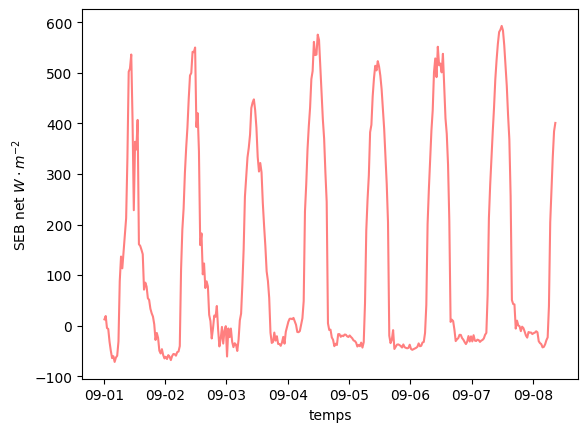

In [4]:
fig=plt.figure()
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)

ax.plot(tps_T2R,SEB_net,color='r',alpha=0.5)
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel("temps")
ax.set_ylabel(r"SEB net $W\cdot m^{-2}$")
plt.show()

C:\Users\evanl\AppData\Local\Temp\ipykernel_19008\2769711327.py:61: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"taux d'ablation moyen sur la PI : {ablation_totale[-1]/ablation_totale.size} m/jour +/- {(incer_ablation_rayonnement_tot[-1]+incer_ablation_fluxt_tot[-1])/ablation_totale.size}")
C:\Users\evanl\AppData\Local\Temp\ipykernel_19008\2769711327.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"ablation totale sur la PI : {ablation_totale[-1]} m  +/- {incer_ablation_rayonnement_tot[-1]+incer_ablation_fluxt_tot[-1]}")
C:\Users\evanl\AppData\Local\Temp\ipykernel_19008\2769711327.py:64: FutureWa

taux d'ablation moyen sur la PI : 0.03206943703833906 m/jour +/- 0.006287425149700599
incertitude moyenne sur le flux de rayonnement : 0.001437125748502994 m/jour
ablation totale sur la PI : 0.2565554963067125 m  +/- 0.050299401197604794
contribution rayonnement 0.19133291013258708 m
incertitude totale sur rayonnement 0.010059880239520959 m
estimation avec la méthode Bulk
taux d'ablation moyen sur la PI : 0.037114766347985224
ablation totale sur la PI : 0.2642524910447517 m +/- 0.050299401197604794
contribution flux turbulents EC :
H : 0.09487083703180307 m
LE : -0.029648250857677614 m
H+LE 0.06522258617412546 m
incertitude ablation flux 0.040239520958083835
soit 25.42240845082179 %
avec methode Bulk :
H : 0.04617332988450097 m
LE : 0.026746251027663544 m
H+LE 0.07291958091216452 m
soit 25.42240845082179 %
extrapolation sur toute la PO (23) jours :
Avec EC l'ablation est alors de 0.8226636258912244 m
Avec Bulk, l'ablation est alors de 0.8536396260036602 m


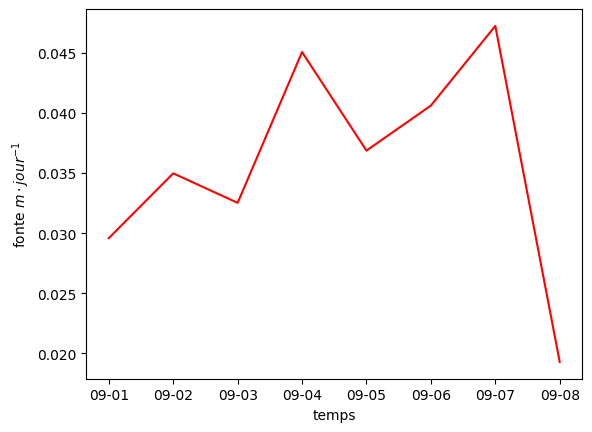

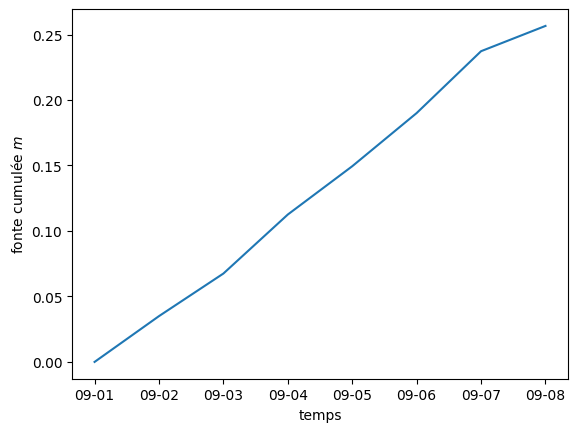

In [5]:
Lf=334.0e3#J/kg : chaleur latente de fusion de l'eau
rho_g=900.0#kg/m^3 masse volumique de la glace (en kg/m3)
#largeur_langue=500.0#m
#longueur_langue=6000.0#m
#S_m2=largeur_langue*longueur_langue
taux_ablation_rayonnement_jour=(Rnet_jour/(Lf*rho_g))*3600.0*24.0

ablation_H_jour=(H_jour/(Lf*rho_g))*3600.0*24.0
ablation_LE_jour=(LE_jour/(Lf*rho_g))*3600.0*24.0

ablation_H_jour_Bulk=(H_jour_Bulk/(Lf*rho_g))*3600.0*24.0
ablation_LE_jour_Bulk=(LE_jour_Bulk/(Lf*rho_g))*3600.0*24.0

incer_flux=pd.Series(10.0, index=tps_T2R).resample('24H').mean()#W/m^2. Valable pour H ET LE !
incer_ablation_flux=2.0*incer_flux/(Lf*rho_g)*3600.0*24.0
incer_rayonnement=pd.Series(5.0, index=tps_T2R).resample('24H').mean()#W/m^2

taux_ablation=taux_ablation_rayonnement_jour+ablation_H_jour+ablation_LE_jour
#incer_ablation_rayonnement=(0.05*(SWin_jour-SWout_jour)+0.1*SWin_jour)*3600.0*24.0/(Lf*rho_g)
incer_ablation_rayonnement=incer_rayonnement/(Lf*rho_g)*3600.0*24.0
taux_ablation_Bulk=taux_ablation_rayonnement_jour+ablation_H_jour_Bulk+ablation_LE_jour_Bulk

fig=plt.figure()
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
ax.plot(taux_ablation,color='r')
ax.set_xlabel("temps")
ax.set_ylabel(r"fonte $m\cdot jour^{-1}$")
ax.xaxis.set_major_formatter(date_format)
#plt.savefig(repertoire_figures+"T2R_fonte_jour.png")

ablation_totale=(taux_ablation.cumsum()-taux_ablation.values[0])
ablation_totale_Bulk=(taux_ablation_Bulk.cumsum()-taux_ablation_Bulk.values[0])

ablation_totale_H=(ablation_H_jour.cumsum()-ablation_H_jour.values[0])
ablation_totale_H_Bulk=(ablation_H_jour_Bulk.cumsum()-ablation_H_jour_Bulk.values[0])

ablation_totale_LE=(ablation_LE_jour.cumsum()-ablation_LE_jour.values[0])
ablation_totale_LE_Bulk=(ablation_LE_jour_Bulk.cumsum()-ablation_LE_jour_Bulk.values[0])

ablation_totale_rayonnement=(taux_ablation_rayonnement_jour.cumsum()-taux_ablation_rayonnement_jour.values[0])
incer_ablation_rayonnement_tot=(incer_ablation_rayonnement.cumsum()-incer_ablation_rayonnement.values[0])
incer_ablation_fluxt_tot=(incer_ablation_flux.cumsum()-incer_ablation_flux.values[0])

fig=plt.figure()
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
ax.plot(ablation_totale)
ax.set_xlabel("temps")
ax.set_ylabel(r"fonte cumulée $m$")
ax.xaxis.set_major_formatter(date_format)
#plt.savefig(repertoire_figures+"T2R_fonte_tot.png")
debut_PO=np.datetime64("2023-08-16 00:00:00")
fin_PO=np.datetime64("2023-09-08 07:00:00")
tps_PO=pd.Timedelta(fin_PO-debut_PO).days
tps_PI=pd.Timedelta(tps_T2R[-1]-tps_T2R[0]).days

taux_fonte_moy=np.mean(taux_ablation)
taux_fonte_moy_Bulk=np.mean(taux_ablation_Bulk)

print(f"taux d'ablation moyen sur la PI : {ablation_totale[-1]/ablation_totale.size} m/jour +/- {(incer_ablation_rayonnement_tot[-1]+incer_ablation_fluxt_tot[-1])/ablation_totale.size}")
print(f"incertitude moyenne sur le flux de rayonnement : {incer_ablation_rayonnement.mean()} m/jour")
print(f"ablation totale sur la PI : {ablation_totale[-1]} m  +/- {incer_ablation_rayonnement_tot[-1]+incer_ablation_fluxt_tot[-1]}")
print(f"contribution rayonnement {ablation_totale_rayonnement[-1]} m")
print(f"incertitude totale sur rayonnement {incer_ablation_rayonnement_tot[-1]} m")
print(f"estimation avec la méthode Bulk")
print(f"taux d'ablation moyen sur la PI : {taux_fonte_moy_Bulk}")
print(f"ablation totale sur la PI : {ablation_totale_Bulk[-1]} m +/- {incer_ablation_rayonnement_tot[-1]+incer_ablation_fluxt_tot[-1]}")

print(f"contribution flux turbulents EC :")
print(f"H : {ablation_totale_H[-1]} m")
print(f"LE : {ablation_totale_LE[-1]} m")
print(f"H+LE {ablation_totale_H[-1]+ablation_totale_LE[-1]} m")
print(f"incertitude ablation flux {incer_ablation_fluxt_tot[-1]}")
print(f"soit {100.0*(ablation_totale_H[-1]+ablation_totale_LE[-1])/ablation_totale[-1]} %")

print(f"avec methode Bulk :")
print(f"H : {ablation_totale_H_Bulk[-1]} m")
print(f"LE : {ablation_totale_LE_Bulk[-1]} m")
print(f"H+LE {ablation_totale_H_Bulk[-1]+ablation_totale_LE_Bulk[-1]} m")
print(f"soit {100.0*(ablation_totale_H[-1]+ablation_totale_LE[-1])/ablation_totale[-1]} %")

print(f"extrapolation sur toute la PO ({tps_PO}) jours :")
print(f"Avec EC l'ablation est alors de {taux_fonte_moy*tps_PO} m")
print(f"Avec Bulk, l'ablation est alors de {taux_fonte_moy_Bulk*tps_PO} m")

In [6]:
flux=100#W/m2
print(f"pour F={flux}W/m2, fonte d'environ {100.0*flux/(rho_g*Lf)*3600.0*24.0} cm/jour")

pour F=100W/m2, fonte d'environ 2.8742514970059876 cm/jour


In [7]:
print(Rnet_jour)
print(ablation_H_jour)

TIMESTAMP
2023-09-01     79.319066
2023-09-02     98.197192
2023-09-03     85.916915
2023-09-04    123.013297
2023-09-05    104.938486
2023-09-06    108.423729
2023-09-07    115.546555
2023-09-08     29.642910
Freq: 24H, dtype: float64
2023-09-01    0.008736
2023-09-02    0.007212
2023-09-03    0.009659
2023-09-04    0.010712
2023-09-05    0.013726
2023-09-06    0.019268
2023-09-07    0.018612
2023-09-08    0.015682
Freq: 24H, dtype: float64


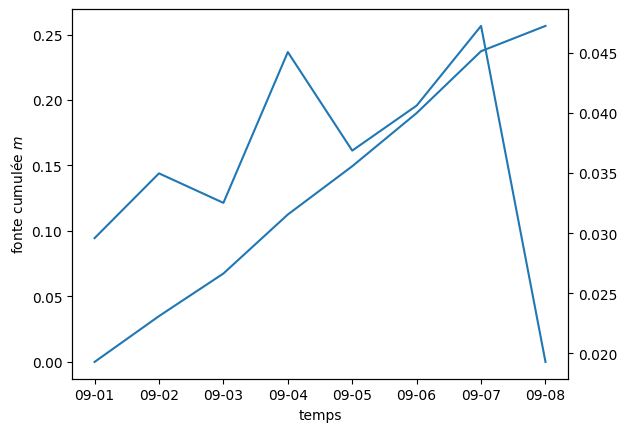

In [8]:
fig=plt.figure()
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.plot(ablation_totale)
ax2.plot(taux_ablation)
ax.set_xlabel("temps")
ax.set_ylabel(r"fonte cumulée $m$")
ax.xaxis.set_major_formatter(date_format)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'flux ($W\\cdot m^{-2}$)')

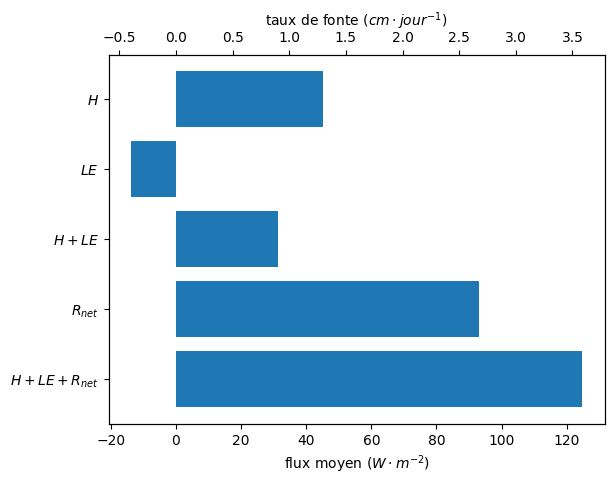

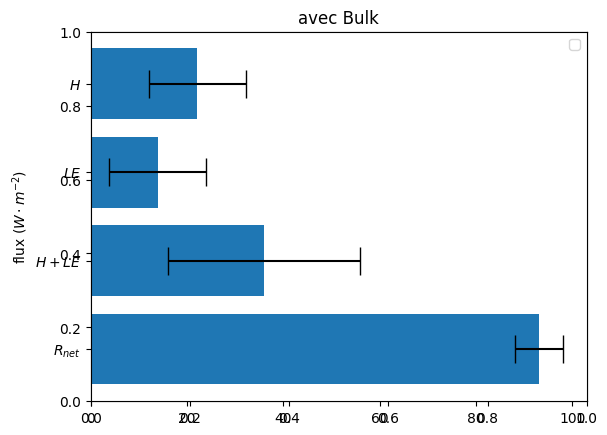

In [28]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax2=ax.twiny()

ax.barh([r"$H+LE+R_{net}$",r"$R_{net}$",r"$H+LE$",r"$LE$",r"$H$"],
       [np.mean(SEB_jour),np.mean(Rnet_jour),np.mean(LE_jour+H_jour),np.mean(LE_jour),np.mean(H_jour)]
        , capsize = 10)
ax2.barh([r"$H+LE+R_{net}$",r"$R_{net}$",r"$H+LE$",r"$LE$",r"$H$"],
       (np.array([np.mean(SEB_jour),np.mean(Rnet_jour),np.mean(LE_jour+H_jour),np.mean(LE_jour),np.mean(H_jour)])/(Lf*rho_g))*1.0e2*3600.0*24.0
        , capsize = 10)
#ax.bar(1, np.mean(Rnet_jour),yerr=5, label=r"$R_{net}$",capsize = 10)
#ax.bar(2, np.mean(LE_jour),yerr=10,label="$LE$",capsize = 10)
#ax.bar(3, np.mean(H_jour),yerr=10,label="$H$",capsize = 10)
ax.set_xlabel(r"flux moyen ($W\cdot m^{-2}$)")
ax2.set_xlabel(r"taux de fonte ($cm\cdot jour^{-1})$")
plt.savefig(repertoire_figures+r"bar_flux_turb.png")

fig=plt.figure()
plt.title("avec Bulk")
ax=fig.add_subplot(111)


ax.barh([r"$R_{net}$",r"$H+LE$",r"$LE$",r"$H$"],
       [np.mean(Rnet_jour),np.mean(LE_jour_Bulk+H_jour_Bulk),np.mean(LE_jour_Bulk),np.mean(H_jour_Bulk)]
        ,xerr=[5,20,10,10], capsize = 10)
#ax.bar(1, np.mean(Rnet_jour),yerr=5, label=r"$R_{net}$",capsize = 10)
#ax.bar(2, np.mean(LE_jour),yerr=10,label="$LE$",capsize = 10)
#ax.bar(3, np.mean(H_jour),yerr=10,label="$H$",capsize = 10)
ax.legend()
ax.set_ylabel(r"flux ($W\cdot m^{-2}$)")


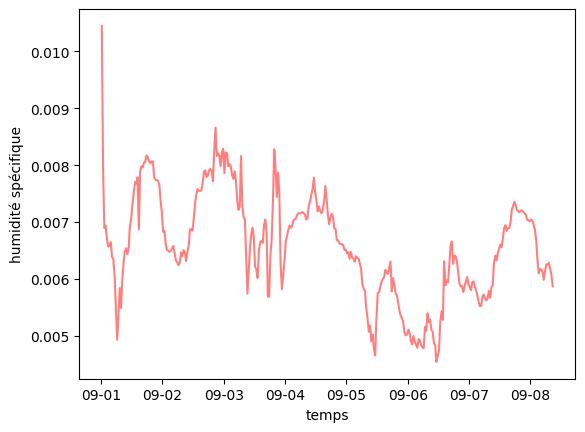

In [10]:
fig=plt.figure()
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
ax.plot(T2_1_30min.coords['temps'].values,T2_1_30min['specific_humidity'].values,color='r',alpha=0.5)
ax.set_xlabel("temps")
ax.set_ylabel(r"humidité spécifique")
ax.xaxis.set_major_formatter(date_format)

In [11]:
tmin_T2=np.datetime64("2023-08-17 18:00:00")
tmax_T2=np.datetime64("2023-09-09 22:00:00")

tmin_meteo=tmin_T2-np.timedelta64(10,'m')
tmax_meteo=tmax_T2#+np.timedelta64(10,'m')

tps_del_inf=np.datetime64("2023-08-26 00:00:00")
tps_del_sup=np.datetime64("2023-09-01 00:00:00")

masque_del=lambda Ds:~((Ds.coords['temps'] >= tps_del_inf) &(Ds.coords['temps'] <= tps_del_sup))

T2R_all=xr.open_dataset(repertoire_fichiers+r"T2_RE_bas_30min_all_final_full_output.nc")
#print(f"T2R_all avant trunc {T2R_all}")
T2R_all=T2R_all.sel(temps=slice(tmin_T2,tmax_T2))

#print(f"T2R_all.coords['temps'].values {T2R_all.coords['temps'].values}")
#print(f"masque_del {masque_del(T2R_all)})")
T2R_all=T2R_all.where(masque_del(T2R_all))
print(f"T2R_all après troncature {T2R_all}")
Ds_meteo_sel=Ds_meteo.sel(temps=slice(tmin_meteo,tmax_meteo))
"""
print(f"bornes  temporelles Ds_T2R_all")
print(f"Ds_T2R_all.coords['temps'].values[0] : {T2R_all.coords['temps'].values[0]}")
print(f"Ds_T2R_all.coords['temps'].values[-1] : {T2R_all.coords['temps'].values[-1]}")
print(f"T2R_all.coords['temps'].values {T2R_all.coords['temps'].values}")
print(f"Ds_T2R_all.coords['temps'].values.size: {T2R_all.coords['temps'].values.size}")

print(f"bornes  temporelles Ds_meteo")
print(f"Ds_meteo.coords['temps'].values[0] : {Ds_meteo.coords['temps'].values[0]}")
print(f"Ds_meteo.coords['temps'].values[-1] : {Ds_meteo.coords['temps'].values[-1]}")
print(f"Ds_meteo.coords['temps'].values.size : {Ds_meteo.coords['temps'].values.size}")
print(f"Ds_meteo.coords['temps'].values {Ds_meteo.coords['temps'].values}")

print(f"bornes  temporelles Ds_meteo_sel")
print(f"Ds_meteo_sel.coords['temps'].values[0] : {Ds_meteo_sel.coords['temps'].values[0]}")
print(f"Ds_meteo_sel.coords['temps'].values[-1] : {Ds_meteo_sel.coords['temps'].values[-1]}")
print(f"Ds_meteo_sel.coords['temps'].values.size: {Ds_meteo_sel.coords['temps'].values.size}")
print(f"Ds_meteo_sel.coords['temps'].values.size%3: {Ds_meteo_sel.coords['temps'].values.size%3}")
print(f"Ds_meteo_sel.coords['temps'].values {Ds_meteo_sel.coords['temps'].values}")
"""
Ds_meteo_moy=Ds_meteo_sel.coarsen(temps=3,side='left').mean()
Ds_meteo_moy=Ds_meteo_sel.where(masque_del(Ds_meteo_moy))

Ds_meteo_jour=Ds_meteo_moy.coarsen(temps=48,boundary='trim').mean()
T2R_all_jour=T2R_all.coarsen(temps=48,boundary='trim').mean()

print(Ds_meteo_moy)
#print(f"Ds_meteo_moy.coords['temps'].values {Ds_meteo_moy.coords['temps'].values}")
Da_Rayonnement=Ds_meteo_moy['LWinCor_Avg']-LW_out+Ds_meteo_moy['SWin_Avg']-Ds_meteo_moy['SWout_Avg']
Da_turb=-(T2R_all['H']+T2R_all['LE'])
Da_SEB_tot=Da_Rayonnement+Da_turb

T2R_all après troncature <xarray.Dataset>
Dimensions:                  (temps: 1069)
Coordinates:
  * temps                    (temps) datetime64[ns] 2023-08-17T18:00:00 ... 2...
Data variables: (12/104)
    daytime                  (temps) float64 1.0 1.0 0.0 0.0 ... nan nan nan nan
    Tau                      (temps) float64 -0.001871 -0.009214 ... nan nan
    qc_Tau                   (temps) float64 2.0 2.0 2.0 2.0 ... nan nan nan nan
    rand_err_Tau             (temps) float64 0.001064 0.006805 ... nan nan
    H                        (temps) float64 -18.51 -7.778 3.417 ... nan nan nan
    qc_H                     (temps) float64 2.0 2.0 2.0 2.0 ... nan nan nan nan
    ...                       ...
    w_mean                   (temps) float64 -0.1816 -0.05353 ... nan nan
    ts_mean                  (temps) float64 280.1 280.1 279.0 ... nan nan nan
    co2_mean                 (temps) float64 13.19 13.18 13.26 ... nan nan nan
    instrument_height        (temps) float64 1.2 1.2 1

C:\Users\evanl\AppData\Local\Programs\Python\Python312\Lib\site-packages\xarray\core\nanops.py:118: RuntimeWarning: invalid value encountered in divide
  data = data / (valid_count - ddof)
C:\Users\evanl\AppData\Local\Programs\Python\Python312\Lib\site-packages\xarray\core\nanops.py:118: RuntimeWarning: invalid value encountered in divide
  data = data / (valid_count - ddof)
C:\Users\evanl\AppData\Local\Programs\Python\Python312\Lib\site-packages\xarray\core\nanops.py:118: RuntimeWarning: invalid value encountered in divide
  data = data / (valid_count - ddof)


In [12]:
print(T2R_all_jour['LE'].values)

[ -9.23797578   7.01531296  -6.03361506  -8.24367104  -3.64642467
  -8.72098063  -3.08849161 -20.47701217 -36.40094167          nan
          nan          nan          nan          nan  10.71445771
   2.75867429   3.66165021   3.29844758   4.42509827  12.08281333
  13.63258521   6.20640655]


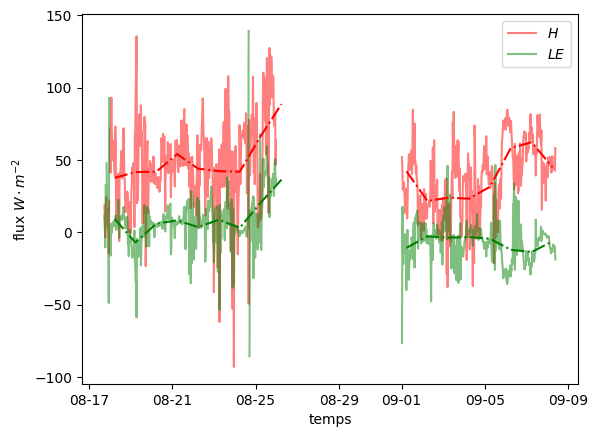

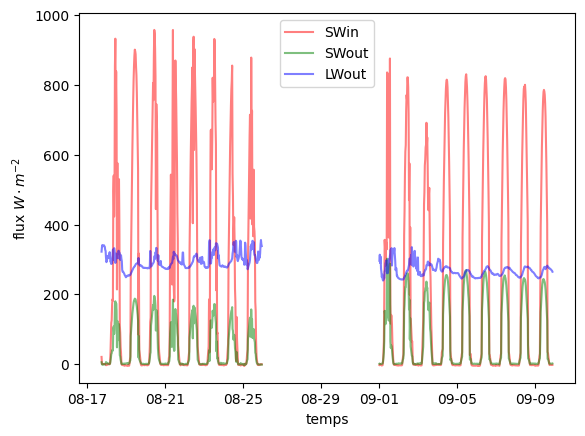

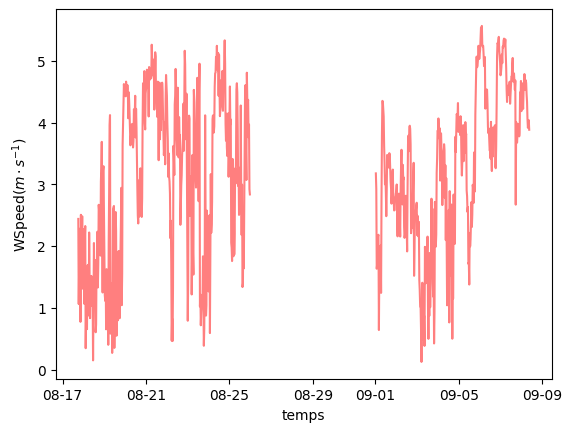

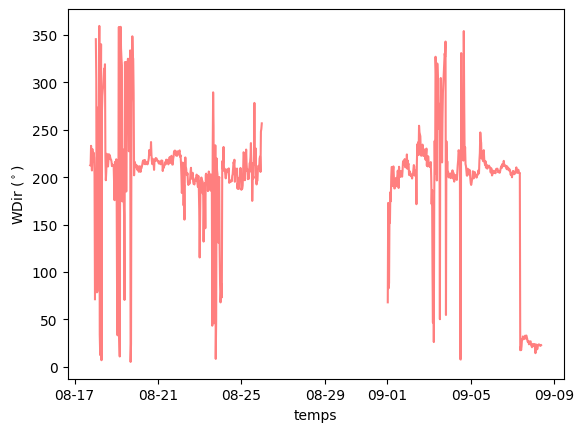

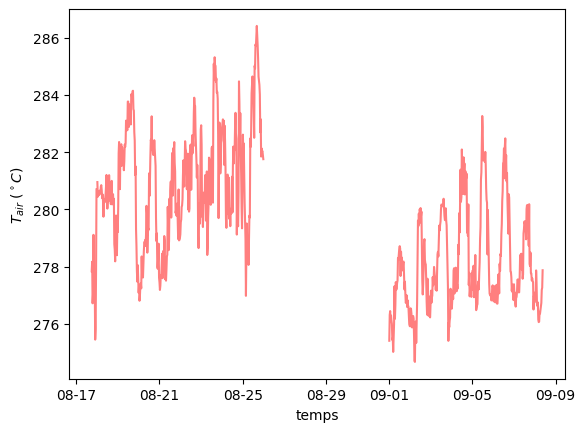

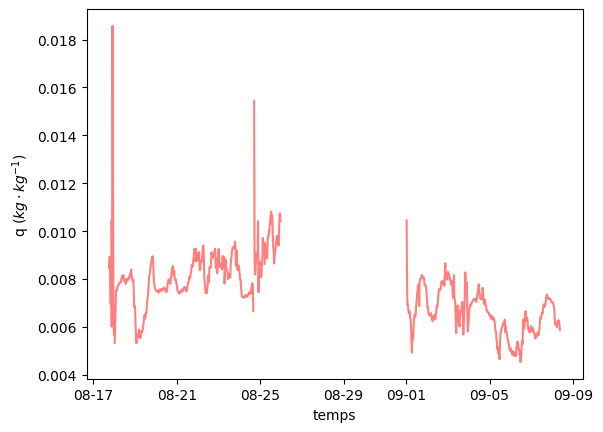

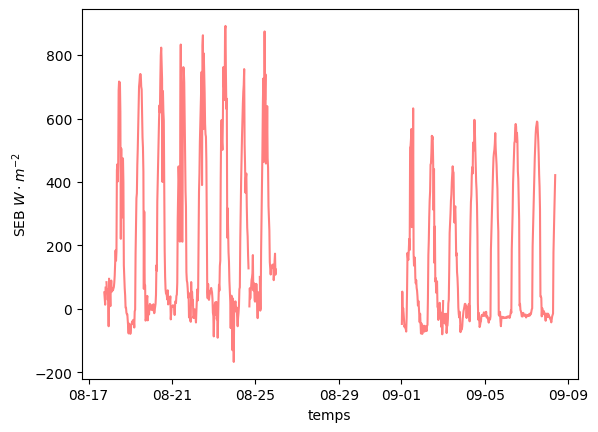

In [13]:
fig=plt.figure()
#plt.title(r"$H$ et $LE$ Convention de signe glaciologie")
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
plt.plot(T2R_all.coords['temps'].values,-T2R_all['H'].values, color='r',label=r"$H$",alpha=0.5)
plt.plot(T2R_all.coords['temps'].values,-T2R_all['LE'].values, color='g',label=r"$LE$",alpha=0.5)
plt.plot(T2R_all_jour.coords['temps'].values,-T2R_all_jour['H'].values, color='r',linestyle='-.')
plt.plot(T2R_all_jour.coords['temps'].values,-T2R_all_jour['LE'].values, color='g',linestyle='-.')

ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel("temps")
ax.set_ylabel(r"flux $W\cdot m^{-2}$")
ax.legend()
#ax.grid(True)

fig=plt.figure()
#plt.title(r"$H$ et $LE$ Convention de signe glaciologie")
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
plt.plot(Ds_meteo_moy.coords['temps'].values,Ds_meteo_moy['SWin_Avg'].values, color='r',label=r"SWin",alpha=0.5)
plt.plot(Ds_meteo_moy.coords['temps'].values,Ds_meteo_moy['SWout_Avg'].values, color='g',label=r"SWout",alpha=0.5)
plt.plot(Ds_meteo_moy.coords['temps'].values,Ds_meteo_moy['LWinCor_Avg'].values, color='b',label=r"LWout",alpha=0.5)

ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel("temps")
ax.set_ylabel(r"flux $W\cdot m^{-2}$")
ax.legend()


fig=plt.figure()
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
ax.plot(T2R_all.coords['temps'].values,T2R_all['u_rot'].values, color='r',alpha=0.5)
ax.set_xlabel("temps")
ax.set_ylabel(r"WSpeed($m\cdot s^{-1}$)")
ax.xaxis.set_major_formatter(date_format)

fig=plt.figure()
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
ax.plot(T2R_all.coords['temps'].values,(T2R_all['wind_dir'].values+180)%360, color='r',alpha=0.5)
ax.set_xlabel("temps")
ax.set_ylabel(r"WDir ($^\circ$)")
ax.xaxis.set_major_formatter(date_format)

fig=plt.figure()
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
ax.plot(T2R_all.coords['temps'].values,T2R_all['air_temperature'].values, color='r',alpha=0.5)
ax.set_xlabel("temps")
ax.set_ylabel(r"$T_{air}$ ($^\circ C$)")
ax.xaxis.set_major_formatter(date_format)

fig=plt.figure()
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
ax.plot(T2R_all.coords['temps'].values,T2R_all['specific_humidity'].values, color='r',alpha=0.5)
ax.set_xlabel("temps")
ax.set_ylabel(r"q ($kg\cdot kg^{-1}$)")
ax.xaxis.set_major_formatter(date_format)

fig=plt.figure()
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
ax.plot(Da_SEB_tot.coords['temps'].values,Da_SEB_tot.values, color='r',alpha=0.5)
ax.set_xlabel("temps")
ax.set_ylabel(r"SEB $W\cdot m^{-2}$")
ax.xaxis.set_major_formatter(date_format)

fonte totale [ 0.          6.17248733 12.49482953 18.74023804 25.23930069 32.25849195
 38.37599702 44.65823099 50.16072078 52.02420634 52.02420634 52.02420634
 52.02420634 52.02420634 54.2852768  58.19153969 61.4483854  65.14023921
 69.1441992  73.23846972 77.73527423] cm


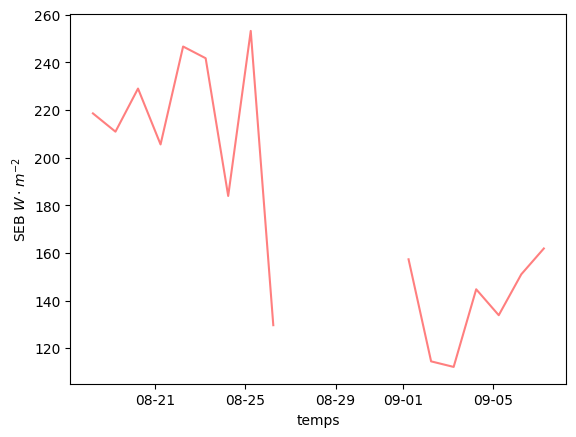

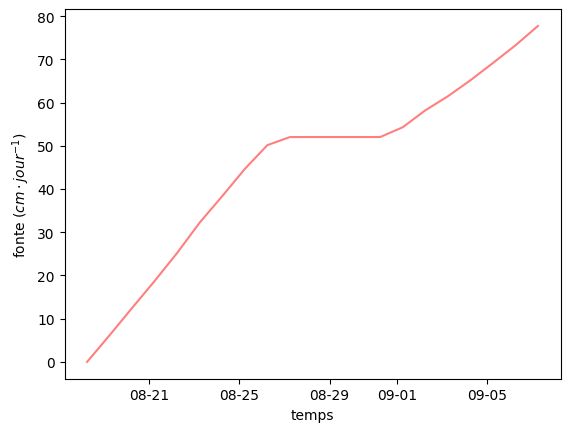

In [14]:
import scipy.integrate

Lf=334.0e3#J/kg : chaleur latente de fusion de l'eau
rho_g=900.0#kg/m^3 masse volumique de la glace (en kg/m3)


Da_SEB_jour=Da_SEB_tot.coarsen(temps=48,boundary='trim').mean()
Da_fonte_jour=Da_SEB_jour.fillna(value=0)/(Lf*rho_g)*3600*24*100#cm/jour

fonte_totale=scipy.integrate.cumulative_trapezoid(Da_fonte_jour.values,dx=1,initial=0)

print(f"fonte totale {fonte_totale} cm")

fig=plt.figure()
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
ax.plot(Da_SEB_jour.coords['temps'].values,Da_SEB_jour.values, color='r',alpha=0.5)
ax.set_xlabel("temps")
ax.set_ylabel(r"SEB $W\cdot m^{-2}$")
ax.xaxis.set_major_formatter(date_format)

fig=plt.figure()
date_format=mpl.dates.DateFormatter("%m-%d")
ax = fig.add_subplot(111)
ax.plot(Da_fonte_jour.coords['temps'].values,fonte_totale, color='r',alpha=0.5)
ax.set_xlabel("temps")
ax.set_ylabel(r"fonte ($cm\cdot jour^{-1}$)")
ax.xaxis.set_major_formatter(date_format)

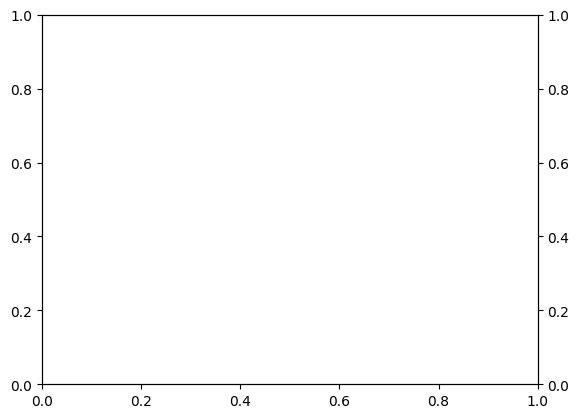

In [15]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax2=ax.twinx()


In [16]:

# Définir D1 avec des coordonnées
D1 = xr.DataArray([1,3,4], dims=["x"], coords={"x": [0, 1, 2]})

# Définir D2 avec d'autres coordonnées
D2 = xr.DataArray([0,2,4,6], dims=["x"], coords={"x": [0,1,2,3]})

print(f" D1 {D1}")
print(f" D2 {D2}")
print(f"D1+D2 {D1+D2}")
print(D1.sel(x=slice(1,2),drop=True))

 D1 <xarray.DataArray (x: 3)>
array([1, 3, 4])
Coordinates:
  * x        (x) int32 0 1 2
 D2 <xarray.DataArray (x: 4)>
array([0, 2, 4, 6])
Coordinates:
  * x        (x) int32 0 1 2 3
D1+D2 <xarray.DataArray (x: 3)>
array([1, 5, 8])
Coordinates:
  * x        (x) int32 0 1 2
<xarray.DataArray (x: 2)>
array([3, 4])
Coordinates:
  * x        (x) int32 1 2
